In [41]:
import numpy as np
import pandas as pd

transactions = pd.read_csv('data/provided/sales_train_v2.csv')
print('shape:', transactions.shape)
print('max date_block_num:', transactions['date_block_num'].max())
transactions.head()

shape: (2935849, 6)
max date_block_num: 33


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## Shops

In [42]:
#aggregate sales by shop and month
monthly_shop_totals = transactions.groupby(['date_block_num', 'shop_id'],as_index=False)[['item_cnt_day']].sum()
monthly_shop_totals['item_cnt_day'].describe()

count     1586.00000
mean      2300.25599
std       1906.64723
min         -1.00000
25%       1185.25000
50%       1737.50000
75%       2599.00000
max      16318.00000
Name: item_cnt_day, dtype: float64

In [43]:
monthly_shop_totals = monthly_shop_totals.pivot(index='shop_id', columns='date_block_num', values='item_cnt_day')
print(monthly_shop_totals.shape)

#save file
monthly_shop_totals.to_csv('data/shop_totals_by_month.csv')
monthly_shop_totals.head()

(60, 34)


date_block_num,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
shop_id,,,,,,,,,,,,,,,,,,,,,
0,5578.0,6127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2947.0,3364.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1146.0,488.0,753.0,583.0,553.0,832.0,807.0,875.0,945.0,795.0,...,987.0,907.0,762.0,859.0,843.0,804.0,785.0,942.0,822.0,727.0
3,767.0,798.0,959.0,647.0,710.0,784.0,721.0,890.0,1026.0,793.0,...,977.0,738.0,741.0,740.0,731.0,672.0,535.0,666.0,745.0,613.0
4,2114.0,2025.0,2060.0,285.0,1211.0,1464.0,1378.0,1713.0,1536.0,1482.0,...,1188.0,980.0,978.0,899.0,893.0,793.0,842.0,947.0,732.0,831.0


In [44]:
monthly_shop_totals['shop_total'] = monthly_shop_totals.iloc[:, -34:].sum(axis=1)
shop_totals = monthly_shop_totals[['shop_total']]
shop_totals.to_csv('data/shop_totals_mapping.csv')
shop_totals.head()

date_block_num,shop_total
shop_id,
0,11705.0
1,6311.0
2,30620.0
3,28355.0
4,43942.0


In [45]:
cluster_data = monthly_shop_totals.fillna(0.0)
cluster_data.reset_index(inplace=True)
print(cluster_data.shape)
cluster_data.head()

(60, 36)


date_block_num,shop_id,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,30,31,32,33,shop_total
0,0,5578.0,6127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11705.0
1,1,2947.0,3364.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6311.0
2,2,1146.0,488.0,753.0,583.0,553.0,832.0,807.0,875.0,945.0,...,907.0,762.0,859.0,843.0,804.0,785.0,942.0,822.0,727.0,30620.0
3,3,767.0,798.0,959.0,647.0,710.0,784.0,721.0,890.0,1026.0,...,738.0,741.0,740.0,731.0,672.0,535.0,666.0,745.0,613.0,28355.0
4,4,2114.0,2025.0,2060.0,285.0,1211.0,1464.0,1378.0,1713.0,1536.0,...,980.0,978.0,899.0,893.0,793.0,842.0,947.0,732.0,831.0,43942.0


In [46]:
def get_quarterly_counts():
    yr_label = '2013'
    qtr_label = 'q1'
    for x in range(0, 33, 3):
        if x >= 24:
            yr_label = '2015'
        elif x >= 12:
            yr_label = '2014'
        
        if (x % 12) < 3:
            qtr_label = 'q1'
        elif (x % 12) <6:
            qtr_label = 'q2'
        elif (x % 12) <9:
            qtr_label = 'q3'
        else:
            qtr_label = 'q4'

        lbl = yr_label + qtr_label
        cluster_data[lbl] = cluster_data[x] + cluster_data[x+1] + cluster_data[x+2]
    #cluster_data['2015q4'] = cluster_data[33]
    
#sum up quarterly totals
get_quarterly_counts()
cluster_data = cluster_data[['2013q1','2013q2','2013q3','2013q4','2014q1','2014q2','2014q3','2014q4','2015q1','2015q2','2015q3']]
cluster_data.head()

date_block_num,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3
0,11705.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6311.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2387.0,1968.0,2627.0,2979.0,2791.0,2658.0,2714.0,4058.0,2656.0,2506.0,2549.0
3,2524.0,2141.0,2637.0,2897.0,2946.0,2289.0,2620.0,3143.0,2456.0,2143.0,1946.0
4,6199.0,2960.0,4627.0,5216.0,3975.0,3692.0,3568.0,4622.0,3146.0,2585.0,2521.0


In [47]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display # Allows the use of display() for DataFrames

def pca_results(good_data, pca):
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Expl. Var.\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

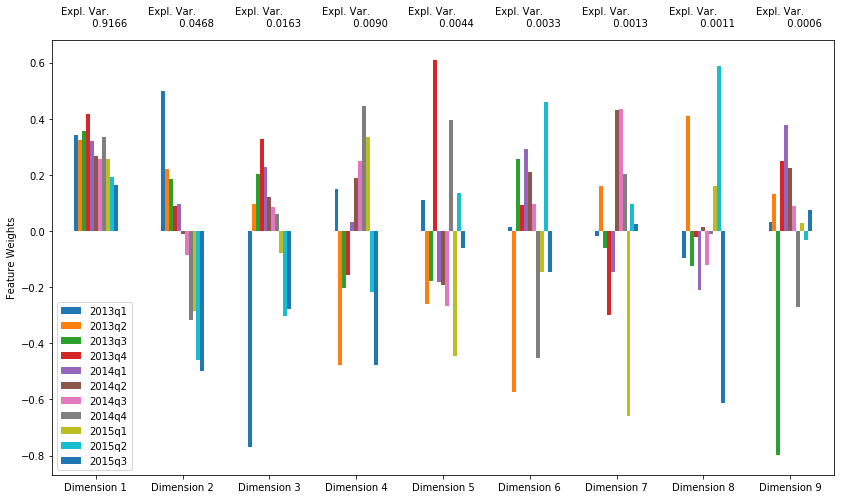

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
pca.fit(cluster_data)

pca_results = pca_results(cluster_data, pca)

In [49]:
pca = PCA(n_components=1)
pca.fit(cluster_data)

reduced_data = pca.transform(cluster_data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1'])

In [50]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

def get_clusterer(data, n):
    clusterer = GaussianMixture(n_components=n)
    clusterer.fit(data)

    preds = clusterer.predict(data)
    centers = clusterer.means_
    score = silhouette_score(data, preds)
    print("n={}: score: {}".format(n, score))
    return clusterer, score, preds 

In [51]:
for n in range(2, 20):   
    get_clusterer(reduced_data, n)

n=2: score: 0.7525023885669293
n=3: score: 0.6996013413905096
n=4: score: 0.6503569402917504
n=5: score: 0.6726459502819931
n=6: score: 0.5782785061829538
n=7: score: 0.6072036537928327
n=8: score: 0.5816331392386306
n=9: score: 0.6244754775501686
n=10: score: 0.6167766420170292
n=11: score: 0.6258137503382694
n=12: score: 0.6204350646372655
n=13: score: 0.5959578989931481
n=14: score: 0.5888861850611808
n=15: score: 0.6167144840342552
n=16: score: 0.5837302548159314
n=17: score: 0.5649720708782316
n=18: score: 0.5716350259239088
n=19: score: 0.5409230885566043


In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(cluster_data)
scaled_data = scaler.transform(cluster_data)
scaled_data

array([[ 7.51532199e-01, -9.70721525e-01, -9.91328575e-01,
        -9.97388349e-01, -1.00151879e+00, -1.03020766e+00,
        -1.06676192e+00, -1.07899080e+00, -9.80140408e-01,
        -9.00687738e-01, -9.21687853e-01],
       [-7.13193986e-02, -9.70721525e-01, -9.91328575e-01,
        -9.97388349e-01, -1.00151879e+00, -1.03020766e+00,
        -1.06676192e+00, -1.07899080e+00, -9.80140408e-01,
        -9.00687738e-01, -9.21687853e-01],
       [-6.69923342e-01, -6.33139914e-01, -5.75306780e-01,
        -5.93041721e-01, -5.10958168e-01, -4.67111035e-01,
        -4.74312470e-01, -4.12244576e-01, -4.16631190e-01,
        -2.68546509e-01, -2.24227867e-01],
       [-6.49024071e-01, -6.03464295e-01, -5.73723142e-01,
        -6.04171773e-01, -4.83714565e-01, -5.45283591e-01,
        -4.94832090e-01, -5.62582869e-01, -4.59064113e-01,
        -3.60113655e-01, -3.89221344e-01],
       [-8.84049342e-02, -4.62976826e-01, -2.58579110e-01,
        -2.89408486e-01, -3.02852194e-01, -2.48058398e-01,
  

In [53]:
for n in range(2, 20):   
    get_clusterer(scaled_data, n)

n=2: score: 0.6945150775743526
n=3: score: 0.4460232050034596
n=4: score: 0.45536370449994734
n=5: score: 0.3207135456789011
n=6: score: 0.3511772073251118
n=7: score: 0.31289749508496606
n=8: score: 0.3151645452629784
n=9: score: 0.2647854994080246
n=10: score: 0.3021268923360817
n=11: score: 0.25229008798199476
n=12: score: 0.24879345910254366
n=13: score: 0.23636290489969455
n=14: score: 0.25318756887875704
n=15: score: 0.2662504209316384
n=16: score: 0.2978009804534551
n=17: score: 0.2515082781519692
n=18: score: 0.22272086048564205
n=19: score: 0.25610704666360434


In [54]:
clusterer, score, preds = get_clusterer(cluster_data, 2)

shop_clusters = pd.DataFrame(preds, columns=['shop_type'])
shop_types = pd.concat([shop_clusters, cluster_data], axis=1)
shop_types.head(20)

n=2: score: 0.6986831167579165


,shop_type,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3
0,0,11705.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,6311.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2387.0,1968.0,2627.0,2979.0,2791.0,2658.0,2714.0,4058.0,2656.0,2506.0,2549.0
3,0,2524.0,2141.0,2637.0,2897.0,2946.0,2289.0,2620.0,3143.0,2456.0,2143.0,1946.0
4,0,6199.0,2960.0,4627.0,5216.0,3975.0,3692.0,3568.0,4622.0,3146.0,2585.0,2521.0
5,0,2232.0,3511.0,4073.0,4880.0,4362.0,3587.0,4295.0,4759.0,3614.0,3020.0,3377.0
6,0,12212.0,10037.0,11270.0,13080.0,9258.0,8443.0,7860.0,9820.0,6638.0,5285.0,4784.0
7,0,7468.0,5272.0,7027.0,8419.0,6738.0,5222.0,5442.0,7082.0,5361.0,3792.0,4023.0
8,0,3596.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0,0.0,0.0,0.0,6526.0,0.0,0.0,0.0,6155.0,0.0,-1.0,0.0


In [56]:
#save shop types
shops = pd.read_csv('data/provided/shops.csv')
shop_types = pd.concat([shop_clusters, shops], axis=1).drop(['shop_name'],axis=1)
shop_types.to_csv('data/shop_types.csv')
shop_types.head()

,shop_type,shop_id
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


## Categories

In [57]:
items = pd.read_csv('data/provided/items.csv', index_col=1)
categ_transactions = transactions.merge(items, on=['item_id'], how='left').drop(['item_name'], axis=1)
categ_transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


In [58]:
monthly_categ_totals = categ_transactions.groupby(['date_block_num', 'item_category_id'],as_index=False)[['item_cnt_day']].sum()
monthly_categ_totals['item_cnt_day'].describe()

count     2077.000000
mean      1756.478575
std       3669.113351
min         -1.000000
25%        145.000000
50%        514.000000
75%       1323.000000
max      36277.000000
Name: item_cnt_day, dtype: float64

In [59]:
monthly_categ_totals = monthly_categ_totals.pivot(index='item_category_id', columns='date_block_num', values='item_cnt_day')
print(monthly_categ_totals.shape)

#save file
monthly_categ_totals.to_csv('data/categ_totals_by_month.csv', index=False)
monthly_categ_totals.head()

(84, 34)


date_block_num,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
item_category_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1390.0,1190.0,1025.0,646.0,596.0,667.0,618.0,674.0,792.0,790.0,...,370.0,307.0,229.0,170.0,146.0,104.0,114.0,132.0,89.0,82.0
3,440.0,302.0,293.0,202.0,146.0,150.0,233.0,300.0,383.0,391.0,...,1398.0,834.0,773.0,746.0,667.0,559.0,603.0,975.0,1090.0,1059.0
4,251.0,220.0,226.0,160.0,175.0,176.0,179.0,140.0,86.0,89.0,...,10.0,2.0,2.0,2.0,2.0,1.0,NaN,1.0,NaN,NaN


In [60]:
monthly_categ_totals['categ_total'] = monthly_categ_totals.iloc[:, -34:].sum(axis=1)
categ_totals = monthly_categ_totals[['categ_total']]
categ_totals.to_csv('data/categ_totals_mapping.csv')
categ_totals.head()

date_block_num,categ_total
item_category_id,
0,3.0
1,2.0
2,19597.0
3,29807.0
4,2407.0


In [61]:
cluster_data = monthly_categ_totals.fillna(0.0)
cluster_data.reset_index(inplace=True)
print(cluster_data.shape)
cluster_data.head()

(84, 36)


date_block_num,item_category_id,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,30,31,32,33,categ_total
0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,2,1390.0,1190.0,1025.0,646.0,596.0,667.0,618.0,674.0,792.0,...,307.0,229.0,170.0,146.0,104.0,114.0,132.0,89.0,82.0,19597.0
3,3,440.0,302.0,293.0,202.0,146.0,150.0,233.0,300.0,383.0,...,834.0,773.0,746.0,667.0,559.0,603.0,975.0,1090.0,1059.0,29807.0
4,4,251.0,220.0,226.0,160.0,175.0,176.0,179.0,140.0,86.0,...,2.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,2407.0


In [62]:
#sum up quarterly totals     
get_quarterly_counts()
cluster_data = cluster_data[['2013q1','2013q2','2013q3','2013q4','2014q1','2014q2','2014q3','2014q4','2015q1','2015q2','2015q3']]
cluster_data.head()

date_block_num,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3
0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3605.0,1909.0,2084.0,3741.0,2726.0,1439.0,1048.0,1302.0,906.0,420.0,335.0
3,1035.0,498.0,916.0,4139.0,4229.0,2240.0,3337.0,4709.0,3005.0,1972.0,2668.0
4,697.0,511.0,405.0,284.0,200.0,132.0,102.0,56.0,14.0,5.0,1.0


In [63]:
#scale features
scaler.fit(cluster_data)
scaled_data = scaler.transform(cluster_data)
scaled_data

array([[-3.38058185e-01, -3.54515357e-01, -3.76950674e-01,
        -4.21285242e-01, -4.22912314e-01, -4.31924690e-01,
        -4.61035303e-01, -5.26279892e-01, -5.02272589e-01,
        -4.73042766e-01, -5.35862826e-01],
       [-3.38058185e-01, -3.54603083e-01, -3.76950674e-01,
        -4.21285242e-01, -4.22912314e-01, -4.31924690e-01,
        -4.61035303e-01, -5.26279892e-01, -5.02272589e-01,
        -4.73042766e-01, -5.35862826e-01],
       [-8.63898847e-02, -1.87133670e-01, -2.01260020e-01,
        -1.21015880e-01, -1.39657068e-01, -2.52987739e-01,
        -3.22615746e-01, -3.80201300e-01, -3.64367475e-01,
        -3.95142932e-01, -4.61253680e-01],
       [-2.65903493e-01, -3.10915410e-01, -2.99727718e-01,
        -8.90706230e-02,  1.65177798e-02, -1.53384892e-01,
        -2.02852451e-02,  2.04890426e-03, -4.48720741e-02,
        -1.07284499e-01,  5.83377770e-02],
       [-2.89512676e-01, -3.09774969e-01, -3.42807337e-01,
        -3.98490134e-01, -4.02130564e-01, -4.15510738e-01,
  

In [64]:
for n in range(2, 15):
    get_clusterer(scaled_data, n)

n=2: score: 0.8508244422804313
n=3: score: 0.8275288357830968
n=4: score: 0.8138174504099983
n=5: score: 0.36811358842843317
n=6: score: 0.7543831264884518
n=7: score: 0.35281419768718364
n=8: score: 0.39159152089924326
n=9: score: 0.38273828599991494
n=10: score: 0.2739676188227777
n=11: score: 0.4669243074225453
n=12: score: 0.3953716470020332
n=13: score: 0.438387156329619
n=14: score: 0.43537009306917024


In [65]:
clusterer, score, preds = get_clusterer(cluster_data, 6)

categ_clusters = pd.DataFrame(preds, columns=['categ_type'])
categ_types = pd.concat([categ_clusters, cluster_data], axis=1)
categ_types.head(20)

n=6: score: 0.3642833535455146


,categ_type,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3
0,1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,3605.0,1909.0,2084.0,3741.0,2726.0,1439.0,1048.0,1302.0,906.0,420.0,335.0
3,5,1035.0,498.0,916.0,4139.0,4229.0,2240.0,3337.0,4709.0,3005.0,1972.0,2668.0
4,1,697.0,511.0,405.0,284.0,200.0,132.0,102.0,56.0,14.0,5.0,1.0
5,1,1335.0,885.0,943.0,1162.0,781.0,552.0,556.0,518.0,351.0,162.0,124.0
6,5,2184.0,1408.0,1988.0,3094.0,2406.0,1791.0,1930.0,2379.0,1434.0,859.0,757.0
7,1,0.0,0.0,0.0,0.0,0.0,0.0,214.0,2383.0,1128.0,699.0,729.0
8,1,0.0,0.0,0.0,0.0,0.0,0.0,5714.0,1873.0,0.0,309.0,5804.0
9,1,519.0,357.0,348.0,1591.0,1349.0,1143.0,824.0,2883.0,1439.0,3536.0,1605.0


In [66]:
#save category types
categs = pd.read_csv('data/provided/item_categories.csv')
categ_types = pd.concat([categ_clusters, categs], axis=1).drop(['item_category_name'],axis=1)
categ_types.to_csv('data/categ_types.csv')
categ_types.head()

,categ_type,item_category_id
0,1,0
1,1,1
2,5,2
3,5,3
4,1,4


## Items

In [67]:
monthly_item_totals = transactions.groupby(['date_block_num', 'item_id'],as_index=False)[['item_cnt_day']].sum()
monthly_item_totals.head()

,date_block_num,item_id,item_cnt_day
0,0,19,1.0
1,0,27,7.0
2,0,28,8.0
3,0,29,4.0
4,0,32,299.0


In [68]:
monthly_item_totals = monthly_item_totals.pivot(index='item_id', columns='date_block_num', values='item_cnt_day')
print(monthly_item_totals.shape)

#save file
monthly_item_totals.to_csv('data/item_totals_by_month.csv', index=False)
monthly_item_totals.head()

(21807, 34)


date_block_num,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
item_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
cluster_data = monthly_item_totals.fillna(0.0)
cluster_data.reset_index(inplace=True)
print(cluster_data.shape)
cluster_data.head()

(21807, 35)


date_block_num,item_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
#sum up quarterly totals     
get_quarterly_counts()
cluster_data = cluster_data[['2013q1','2013q2','2013q3','2013q4','2014q1','2014q2','2014q3','2014q4','2015q1','2015q2','2015q3']]
cluster_data.head()

date_block_num,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [71]:
#scale features
scaler.fit(cluster_data)
scaled_data = scaler.transform(cluster_data)
scaled_data

array([[-0.21878326, -0.13897596, -0.09665171, ..., -0.12113775,
        -0.08785368, -0.10989273],
       [-0.21878326, -0.13897596, -0.09665171, ..., -0.12113775,
        -0.08785368, -0.10989273],
       [-0.21878326, -0.13897596, -0.09665171, ..., -0.12113775,
        -0.08785368, -0.10989273],
       ...,
       [-0.21878326, -0.13897596,  0.21760215, ...,  1.01297385,
         0.82429075,  0.88610542],
       [-0.16012974, -0.13897596, -0.09104003, ..., -0.12113775,
        -0.08785368, -0.10989273],
       [-0.21878326, -0.13897596, -0.09665171, ..., -0.12113775,
        -0.08785368, -0.10989273]])

In [74]:
#for n in range(2, 15):
#    get_clusterer(scaled_data, n)

In [75]:
#clusterer, score, preds = get_clusterer(cluster_data, 6)

#item_clusters = pd.DataFrame(preds, columns=['item_type'])
#item_types = pd.concat([item_clusters, cluster_data], axis=1)
#item_types.head(20)

In [76]:
#save item types
#items = pd.read_csv('data/provided/items.csv')
#item_types = pd.concat([item_clusters, items], axis=1).drop(['item_name','item_category_id'],axis=1)
#item_types.to_csv('data/item_types.csv')
#item_types.head()